# User Groups that we are interested in

1. Users that viewed the offer
    1. Did they complete the offer
        - What types of offers did they complete?
    2. Did they at least have transactions
        - What types of offers did they not complete?
        - Can try to see how many transactions there were and what percentage of the offer they completed.

We need to see what types of users fall into each of these categories to see if the offer type changes their completion status

# Library Imports

In [ ]:
import pandas as pd
import numpy as np

from functools import reduce

from sqlalchemy import create_engine

from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading

In [ ]:
conn = create_engine('sqlite:///data/starbucks_data.db')

offers = pd.read_sql('SELECT * FROM offers', conn)
offers_wo_chnl = offers.drop(columns=['offer_notification_channel', 'offer_reward_vs_spend']).drop_duplicates()

users = pd.read_sql('SELECT * FROM users', conn)

users['user_gender'] = users['user_gender'].fillna('N/A')
user_gender_cats = [ 'N/A', 'O', 'F', 'M' ]
users['user_gender'] = pd.Categorical(users['user_gender'], categories=user_gender_cats, ordered=True)

users['user_age_group'] = users['user_age_group'].fillna('N/A')
user_age_cats = ['N/A', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
users['user_age_group'] = pd.Categorical(users['user_age_group'], categories=user_age_cats, ordered=True)

user_income_cats = ['N/A', '<50k', '50k-75k', '75k-100k', '>100k']
users['user_income_group'] = pd.Categorical(users['user_income_group'], categories=user_income_cats, ordered=False)

interactions = pd.read_sql('SELECT * FROM interactions', conn)

offer_recv_view_comp = pd.read_sql('offer_recv_view_comp', conn)
offer_recv_view_comp['offer_completed'] = 1
offer_recv_view_comp['offer_completed'] = 1
offer_recv_view_comp = offer_recv_view_comp.drop( columns=['completed_event_type', 'completed_time'] )

offer_recv_view_nocomp = pd.read_sql('offer_recv_view_nocomp', conn)
offer_recv_view_nocomp['offer_completed'] = 0
offer_recv_view_nocomp = offer_recv_view_nocomp.drop( columns=['completed_event_type', 'completed_time', 'transaction_event_type', 'transaction_time', 'transaction_amount'] )

In [19]:
offer_recv_view_nocomp

,user_id,offer_id,received_event_type,received_time,offer_reward_vs_spend,expiration_time,viewed_event_type,viewed_time,offer_completed
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer received,168,0.0,240,offer viewed,192.0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer received,336,0.0,432,offer viewed,372.0,0
2,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,offer received,408,0.0,480,offer viewed,408.0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,offer received,408,0.0,480,offer viewed,408.0,0
4,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,offer received,408,0.0,480,offer viewed,408.0,0
...,...,...,...,...,...,...,...,...,...
30650,fff7576017104bcc8677a8d63322b5e1,ae264e3637204a6fb9bb56bc8210ddfd,offer received,408,1.0,576,offer viewed,414.0,0
30651,fff8957ea8b240a6b5e634b6ee8eafcf,fafdcd668e3743c1bb461111dcafc2a4,offer received,408,0.2,648,offer viewed,432.0,0
30652,fff8957ea8b240a6b5e634b6ee8eafcf,fafdcd668e3743c1bb461111dcafc2a4,offer received,408,0.2,648,offer viewed,432.0,0
30653,fff8957ea8b240a6b5e634b6ee8eafcf,fafdcd668e3743c1bb461111dcafc2a4,offer received,408,0.2,648,offer viewed,432.0,0


In [12]:
user_transactions = pd.concat([offer_recv_view_comp, offer_recv_view_nocomp])
user_transactions = user_transactions[['user_id', 'offer_id', 'offer_completed']].groupby( ['user_id', 'offer_id'], observed=False, dropna=False ).agg( offers_received=('offer_completed', 'count'), offers_completed=('offer_completed', 'sum') ).reset_index()
user_transactions = pd.merge(user_transactions, offers_wo_chnl, how='inner', on=['offer_id'])
user_transactions = pd.merge(user_transactions, users, how='inner', on=['user_id'])

user_transactions

,user_id,offer_id,offers_received,offers_completed,offer_type,offer_spend_minimum,offer_reward,offer_duration,user_gender,user_age,user_member_since,user_income,user_tenure,user_age_group,user_income_group
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0,informational,0,0,96,M,33.0,2017-04-21 00:00:00.000000,72000.0,1,25-34,50k-75k
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0,informational,0,0,72,M,33.0,2017-04-21 00:00:00.000000,72000.0,1,25-34,50k-75k
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,discount,20,5,240,O,40.0,2018-01-09 00:00:00.000000,57000.0,0,35-44,50k-75k
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,discount,7,3,168,O,40.0,2018-01-09 00:00:00.000000,57000.0,0,35-44,50k-75k
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,bogo,5,5,168,O,40.0,2018-01-09 00:00:00.000000,57000.0,0,35-44,50k-75k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34674,fffad4f4828548d1b5583907f2e9906b,5a8bc65990b245e5a138643cd4eb9837,1,0,informational,0,0,72,M,34.0,2017-01-23 00:00:00.000000,34000.0,1,25-34,<50k
34675,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,2,bogo,5,5,120,M,34.0,2017-01-23 00:00:00.000000,34000.0,1,25-34,<50k
34676,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,discount,20,5,240,F,45.0,2016-11-25 00:00:00.000000,62000.0,2,45-54,50k-75k
34677,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,2,2,discount,10,2,168,F,45.0,2016-11-25 00:00:00.000000,62000.0,2,45-54,50k-75k


In [16]:
offer_transactions = user_transactions.groupby( ['offer_id', 'offer_type', 'offer_spend_minimum', 'offer_reward', 'offer_duration', 'user_gender', 'user_age_group', 'user_income_group', 'user_tenure'], observed=False, dropna=False ).agg( offers_received=('offers_received', 'sum'), offers_completed=('offers_completed', 'sum') ).reset_index()
offer_transactions

,offer_id,offer_type,offer_spend_minimum,offer_reward,offer_duration,user_gender,user_age_group,user_income_group,user_tenure,offers_received,offers_completed
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,bogo,0,0,72,N/A,N/A,N/A,0,0,0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,bogo,0,0,72,N/A,N/A,N/A,1,0,0
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,bogo,0,0,72,N/A,N/A,N/A,2,0,0
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,bogo,0,0,72,N/A,N/A,N/A,3,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,bogo,0,0,72,N/A,N/A,N/A,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3149995,fafdcd668e3743c1bb461111dcafc2a4,informational,20,10,240,M,65+,>100k,1,0,0
3149996,fafdcd668e3743c1bb461111dcafc2a4,informational,20,10,240,M,65+,>100k,2,0,0
3149997,fafdcd668e3743c1bb461111dcafc2a4,informational,20,10,240,M,65+,>100k,3,0,0
3149998,fafdcd668e3743c1bb461111dcafc2a4,informational,20,10,240,M,65+,>100k,4,0,0


<Axes: xlabel='user_income_group', ylabel='offers_completed'>

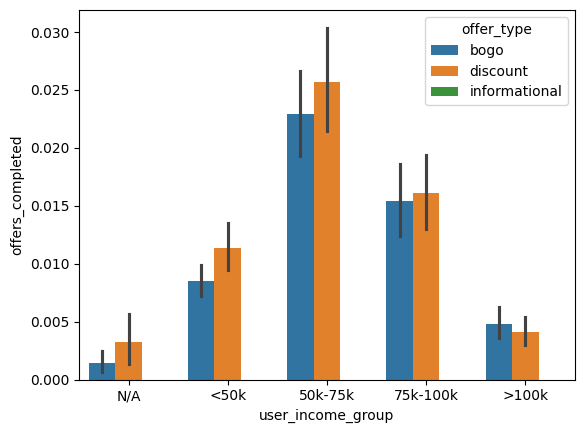

In [18]:
sns.barplot( offer_transactions, x='user_income_group', y='offers_completed', hue='offer_type' )

In [5]:
user_transactions.columns

Index(['user_id', 'offer_id', 'received_event_type', 'received_time',
       'offer_reward_vs_spend', 'expiration_time', 'viewed_event_type',
       'viewed_time', 'offer_completed', 'offer_type', 'offer_spend_minimum',
       'offer_reward', 'offer_duration', 'user_gender', 'user_age',
       'user_member_since', 'user_income', 'user_tenure', 'user_age_group',
       'user_income_group'],
      dtype='object')

In [11]:
user_transactions[['user_id', 'offer_id', 'offer_completed']].groupby( ['user_id', 'offer_id'], observed=False, dropna=False ).agg( offers_received=('offer_completed', 'count'), offers_completed=('offer_completed', 'sum') ).reset_index()

,user_id,offer_id,offers_received,offers_completed
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1
...,...,...,...,...
34674,fffad4f4828548d1b5583907f2e9906b,5a8bc65990b245e5a138643cd4eb9837,1,0
34675,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,2
34676,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1
34677,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,2,2


In [ ]:
user_offer_completions = user_transactions.groupby( ['user_id', 'offer_reward_vs_spend', 'offer_type', 'offer_duration', 'user_gender', 'user_tenure', 'user_age_group', 'user_income_group'], observed=False, dropna=False )['offer_completed'].sum()
display(user_offer_completions)

agg_df = user_transactions.groupby( ['offer_type', 'user_income_group'], observed=False, dropna=False )['offer_completed'].sum()

plt.figure(figsize=(8, 8))
plt.pie(
    agg_df, 
    labels=agg_df.index, 
    autopct='%1.1f%%'
)
# plt.title('Average Completion Percentage by Offer Type')
plt.show()